In [1]:
# %%capture
# !pip install torch-summary
# !pip install torch
# !pip install torchvision

# Loading Data

In [2]:
import torch
import torchvision
import torchsummary
from torchvision import datasets, transforms
import random

### Preprocessing

In [3]:
def normalize(tensor):
    tensor -= tensor.mean().item()
    return tensor  

### Data Loading

In [4]:
PATH = "./dataset"

In [5]:
train_data = torchvision.datasets.CIFAR10(PATH,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomCrop(size=(32, 32), padding=4),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),

        transforms.ToTensor(),
        transforms.Lambda(normalize)
    ])
)

test_data = torchvision.datasets.CIFAR10(PATH,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(normalize)
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dl = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=False)

# Network Block Implementation

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class ResNetInitialBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetInitialBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
    def forward(self, xb):
        out = self.conv(xb)
        return out

In [9]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dropout=0.5):
        super(ResNetBlock, self).__init__()

        pad = (kernel_size - 1) // 2 
        
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=pad)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=pad)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # DROPOUT
        self.dropout = nn.Dropout(dropout) 
        # Correct position to apply dropout in resnet - https://arxiv.org/pdf/2302.06112.pdf
        
        # For skip-connection, 1x1 filter with same stride applied shows better results in original ResNet paper
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

    def forward(self, xb):
        # Described in mini-project document
        # conv -> BN -> relu -> conv -> BN
        if self.downsample is not None:
            residual = self.downsample(xb)
            
        out = self.conv1(xb)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        
        out = out + residual
        
        out = F.relu(out) # ReLU(S(x) + F(x))
        return out
        

### ResNetLayer Description: 
This is a series of similar connected Residual Blocks. 

The `#channels` in each layer are same (`=in_channels`) and change (to `out_channels`) at layer end

In [10]:
class ResNetLayer(nn.Module):
    def __init__(self, n_blocks, in_channels, out_channels, kernel_size, stride, dropout=0.5):
        super(ResNetLayer, self).__init__()
        # Change: Now only apply stride to 1st block in layer
        blocks_initial = [ResNetBlock(in_channels, out_channels, kernel_size, stride, dropout)]
        blocks_list = []
        
        if n_blocks > 1:
            blocks_initial = [
                ResNetBlock(in_channels, in_channels, kernel_size, stride, dropout)
            ]
            blocks_list = [
                ResNetBlock(in_channels, in_channels, kernel_size, 1, dropout) for _ in range(n_blocks - 2)
            ]
            blocks_list.append(
                ResNetBlock(in_channels, out_channels, kernel_size, 1, dropout)
            )
        
        self.blocks = nn.Sequential(*(blocks_initial + blocks_list))
        
    def forward(self, xb):
        # Described in mini-project document
        out = self.blocks(xb)
        return out

# Final Model Implementation with params

In [11]:
class ResNet(nn.Module):
    def __init__(self, initial_params, resnet_params, linear_params, pooling_size, dropout=0.5):
        super(ResNet, self).__init__()

        in_channels, out_channels = initial_params
        initial_layer = [
            ResNetInitialBlock(in_channels, out_channels)
        ]
        middle_layers = [
            ResNetLayer(
                n_blocks = n_blocks,
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = kernel_size,
                stride = stride,
                dropout = dropout
            )
            for n_blocks, in_channels, out_channels, kernel_size, stride, dropout in resnet_params
        ]
        
        self.network = nn.Sequential(
            * (initial_layer + middle_layers)    
        )
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AvgPool2d(kernel_size=pooling_size, stride=1)
        self.fc = nn.Linear(linear_params, 10)
        
    def forward(self, xb):
        out = self.network(xb)
        # print("Here", xb.shape)
        out = self.pool(out)
        out = self.dropout(out)
        out = out.view(xb.shape[0], -1)
        out = self.fc(out)
        return out

# Train and Eval Code

In [12]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
def n_correct(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  # We can use softmax instead here, but the result is the same
  # Softmax maps largest probability to the largest prediction
  return torch.sum(preds==labels).item()

def evaluate(test_dl, model):
  acc = 0
  n_samples = len(test_dl.dataset)
  with torch.no_grad():
    for imgs, labels in test_dl:
      imgs, labels = imgs.to(device), labels.to(device)
      preds = model(imgs)
      acc += n_correct(preds, labels)
    acc /= n_samples
    return acc

In [14]:
def train(train_dl, test_dl, model, opt, scheduler, loss_fn, epochs, max_test = 0):
  loss_plt = torch.Tensor([0 for _ in range(epochs)])
  for _ in range(epochs):
    for images, labels in train_dl:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      # print(outputs.grad_fn)
      loss = loss_fn(outputs, labels)
      loss_plt[_] += loss.item()
      # print(loss.grad_fn)
      if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    scheduler.step()
    test_acc = evaluate(test_dl, model)
    if test_acc > max_test:
        max_test = test_acc
        torch.save(model.state_dict(), 'model-test.pth')
        
    print("Epoch [{}/{}]: \t Running Loss = {} \t Test Accuracy = {:.4}%".format(_+1, epochs, loss_plt[_]/len(train_dl), str(test_acc*100)))
  return loss_plt, loss_plt/len(train_dl)

# Experimentation

In [15]:
# layers = [(n_blocks, in_channels, out_channels, kernel_size, stride, dropout]
initial_params = (3, 64)
resnet_params = [
    (2, 64, 128, 3, 1, 0),
    (2, 128, 256, 3, 2, 0),
    (3, 256, 256, 3, 2, 0),
    # (2, 512, 512, 3, 2, 0.5),
]

pooling_size = 3
linear_params = 9216
pooling_dropout = 0.5

In [16]:
model = ResNet(initial_params, resnet_params, linear_params, pooling_size, pooling_dropout)
model.to(device)
img_dims = (3, 32, 32)
summary = torchsummary.summary(model, img_dims)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 8, 8]           --
|    └─ResNetInitialBlock: 2-1           [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    └─ResNetLayer: 2-2                  [-1, 128, 32, 32]         --
|    |    └─Sequential: 3-2              [-1, 128, 32, 32]         197,760
|    └─ResNetLayer: 2-3                  [-1, 256, 16, 16]         --
|    |    └─Sequential: 3-3              [-1, 256, 16, 16]         788,736
|    └─ResNetLayer: 2-4                  [-1, 256, 8, 8]           --
|    |    └─Sequential: 3-4              [-1, 256, 8, 8]           3,740,928
├─AvgPool2d: 1-2                         [-1, 256, 6, 6]           --
├─Dropout: 1-3                           [-1, 256, 6, 6]           --
├─Linear: 1-4                            [-1, 10]                  92,170
Total params: 4,821,386
Trainable params: 4,821,386
Non-train

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=70, gamma=0.2) 
epochs = 150

In [18]:
losses = train(train_dl, test_dl, model, optim, scheduler, loss_fn, epochs)

Epoch [1/150]: 	 Running Loss = 2.258410930633545 	 Test Accuracy = 25.8%
Epoch [2/150]: 	 Running Loss = 1.888457179069519 	 Test Accuracy = 29.7%
Epoch [3/150]: 	 Running Loss = 1.7356789112091064 	 Test Accuracy = 37.2%
Epoch [4/150]: 	 Running Loss = 1.5728402137756348 	 Test Accuracy = 41.6%
Epoch [5/150]: 	 Running Loss = 1.385703206062317 	 Test Accuracy = 46.6%
Epoch [6/150]: 	 Running Loss = 1.2398878335952759 	 Test Accuracy = 51.6%
Epoch [7/150]: 	 Running Loss = 1.1334891319274902 	 Test Accuracy = 56.6%
Epoch [8/150]: 	 Running Loss = 1.0564730167388916 	 Test Accuracy = 54.7%
Epoch [9/150]: 	 Running Loss = 1.01204514503479 	 Test Accuracy = 51.1%
Epoch [10/150]: 	 Running Loss = 0.9718426465988159 	 Test Accuracy = 53.8%
Epoch [11/150]: 	 Running Loss = 0.9406372308731079 	 Test Accuracy = 57.3%
Epoch [12/150]: 	 Running Loss = 0.9166358113288879 	 Test Accuracy = 63.6%
Epoch [13/150]: 	 Running Loss = 0.898100733757019 	 Test Accuracy = 64.6%
Epoch [14/150]: 	 Running L

In [19]:
total_loss, avg_loss = losses

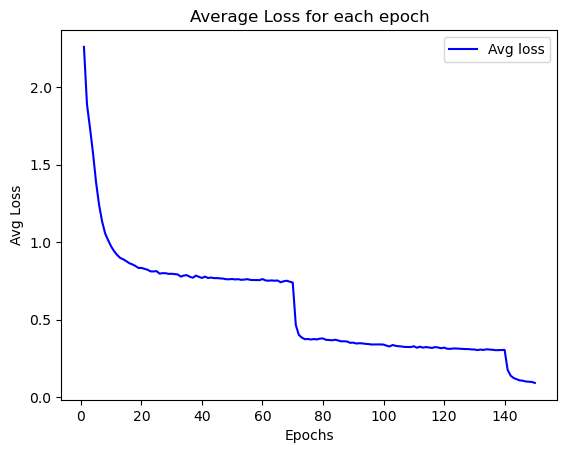

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), avg_loss, 'b', label='Avg loss')
plt.title('Average Loss for each epoch')
plt.xlabel('Epochs')
plt.ylabel('Avg Loss')
plt.legend()
plt.savefig('150_plot.png')
plt.show()

## Evaluation

In [21]:
accuracy = evaluate(train_dl, model)
print("The accuracy of the model on train data is:", str(accuracy*100)+"%")

The accuracy of the model on train data is: 96.662%


In [22]:
accuracy = evaluate(test_dl, model)
print("The accuracy of the model on test data is:", str(accuracy*100)+"%")

The accuracy of the model on test data is: 93.12%


In [23]:
losses = train(train_dl, test_dl, model, optim, scheduler, loss_fn, epochs)

Epoch [1/150]: 	 Running Loss = 0.09294433891773224 	 Test Accuracy = 92.8%
Epoch [2/150]: 	 Running Loss = 0.09200979769229889 	 Test Accuracy = 92.4%
Epoch [3/150]: 	 Running Loss = 0.09225556254386902 	 Test Accuracy = 92.3%
Epoch [4/150]: 	 Running Loss = 0.08956699073314667 	 Test Accuracy = 91.6%
Epoch [5/150]: 	 Running Loss = 0.08992363512516022 	 Test Accuracy = 92.5%
Epoch [6/150]: 	 Running Loss = 0.08574653416872025 	 Test Accuracy = 92.3%
Epoch [7/150]: 	 Running Loss = 0.08885001391172409 	 Test Accuracy = 92.6%
Epoch [8/150]: 	 Running Loss = 0.09230618923902512 	 Test Accuracy = 92.2%
Epoch [9/150]: 	 Running Loss = 0.09304381161928177 	 Test Accuracy = 92.7%
Epoch [10/150]: 	 Running Loss = 0.09053686261177063 	 Test Accuracy = 92.6%
Epoch [11/150]: 	 Running Loss = 0.0881655141711235 	 Test Accuracy = 92.2%
Epoch [12/150]: 	 Running Loss = 0.08912850171327591 	 Test Accuracy = 91.2%
Epoch [13/150]: 	 Running Loss = 0.09491169452667236 	 Test Accuracy = 91.0%
Epoch [14

# Evaluation

In [24]:
model.to('cpu')

ResNet(
  (network): Sequential(
    (0): ResNetInitialBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResNetLayer(
      (blocks): Sequential(
        (0): ResNetBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0, inplace=False)
          (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ResNetBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), pa

In [25]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [26]:
from io import BytesIO
with open('model-test.pth', 'rb') as f:
    buffer = BytesIO(f.read())

# Load the state dictionary from the buffer
state_dict = torch.load(buffer, map_location=torch.device('cpu'))

In [27]:
# model = torch.load_state_dict(state_dict, strict=True, assign=False)
model.load_state_dict(state_dict)
model.to('cuda')
model.eval()

ResNet(
  (network): Sequential(
    (0): ResNetInitialBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResNetLayer(
      (blocks): Sequential(
        (0): ResNetBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0, inplace=False)
          (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ResNetBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), pa

In [28]:
accuracy = evaluate(train_dl, model)
print("The accuracy of the model on train data is:", str(accuracy*100)+"%")

The accuracy of the model on train data is: 99.406%


In [29]:
accuracy = evaluate(test_dl, model)
print("The accuracy of the model on test data is:", str(accuracy*100)+"%")

The accuracy of the model on test data is: 94.48%


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd

# Function to load CIFAR batch
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load test data
test_batch = load_cifar_batch('../cifar_test_nolabels.pkl')
test_images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Define transformation for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(normalize),
])


# Apply data augmentation
augmented_test_images = torch.stack([transform(image) for image in test_images]).to(device)
# test_dl = 
test_dl_new = torch.utils.data.DataLoader(augmented_test_images,batch_size=64,shuffle=False)
# Load the trained model
# model = ModifiedResNet()
# checkpoint = torch.load('modified_resnet_model.pth')

# Check the keys in the checkpoint dictionary
# print(checkpoint.keys())

# Assuming the model state dictionary is saved under a different key
# Adjust this according to the actual key in your checkpoint file
# model.load_state_dict(checkpoint)

# Evaluate the model on test data
model.eval()
with torch.no_grad():
    outputs = model(augmented_test_images)
    _, predicted = torch.max(outputs, 1)
    
    # Display the first 10 test images and predicted labels
    # plt.figure(figsize=(20, 4))
    # for i in range(10):
    #     plt.subplot(1, 10, i+1)
    #     plt.imshow(test_images[i])
    #     plt.title(label_names[predicted[i].item()].decode('utf-8'))
    #     plt.axis('off')
    #     plt.show()

# Save the output in output.csv containing ID, Labels
predicted = predicted.cpu()
output_data = {'ID': np.arange(len(predicted)), 'Labels': predicted.numpy()}
output_df = pd.DataFrame(output_data)
output_df.to_csv('output2.csv', index=False)

In [31]:
print(output_df['Labels'].value_counts())

Labels
3    1150
5    1093
1    1050
9    1041
8    1033
7    1020
4     951
2     941
6     896
0     825
Name: count, dtype: int64


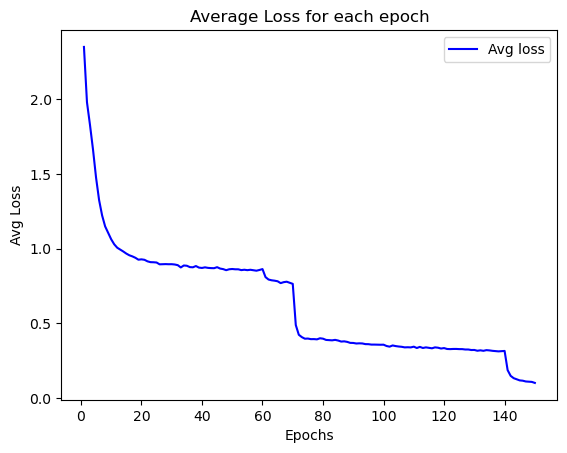

In [32]:
import matplotlib.pyplot as plt

avg_loss += losses[1]

plt.plot(range(1, len(avg_loss)+1), avg_loss, 'b', label='Avg loss')
plt.title('Average Loss for each epoch')
plt.xlabel('Epochs')
plt.ylabel('Avg Loss')
plt.legend()
plt.savefig('300_plot.png')
plt.show()

In [33]:
f = open("test_results.txt", "w")
f.write(str(evaluate(test_dl, model)))
f.close()

In [34]:
f = open("train_results.txt", "w")
f.write(str(evaluate(train_dl, model)))
f.close()